In [1]:
import glob
import os
from concurrent.futures import ThreadPoolExecutor

import pysam
import pandas as pd
from sklearn.model_selection import train_test_split

from siren.utils.squiggletools import SquiggleFile, SquiggleFileLegacy

In [2]:
def classify_transcripts(bam_file_path):
    # Read BAM file
    bam_file = pysam.AlignmentFile(bam_file_path, "rb")
    
    # Extract necessary information from BAM file
    bam_arr = []
    for aln in bam_file.fetch():
        bam_arr.append({
            'query_name': aln.query_name,
            'reference_name': aln.reference_name,
            'sequence': len(aln.seq) 
        })
    df_bam = pd.DataFrame(bam_arr)

    # Extract max length and sequence length
    df_bam['max_len'] = df_bam['reference_name'].str.split('|').str[6].astype(int)
    df_bam['seq_len'] = pd.to_numeric(df_bam['sequence'], errors='coerce')

    # Retain only sequences longer than 100 bp
    df_bam = df_bam[((df_bam['sequence'] / df_bam['seq_len']) > 0.2)]

    # Extract transcript name
    df_bam['transcript_name'] = df_bam['reference_name'].str.split('|').str[4]

    # Classify transcripts as "mt" or "non-mt"
    df_bam['class'] = df_bam['transcript_name'].apply(lambda x: 'mt' if x.split('-')[0] == 'MT' else 'non-mt')

    # Count occurrences of each transcript
    transcript_counts = df_bam['reference_name'].value_counts()

    # Retain only transcripts with at least 20 copies
    valid_transcripts = transcript_counts[transcript_counts > 20].index
    df_bam = df_bam[df_bam['reference_name'].isin(valid_transcripts)]

    return df_bam

def extract_signal_dir(directory, query_names):
    signals = []
    found_query_names = []
    query_names_set = set(query_names)  # For faster lookup

    try:
        # Fetch both fast5 and pod5 files in a single search
        all_files = glob.glob(os.path.join(directory, "*.fast5")) + glob.glob(os.path.join(directory, "*.pod5"))

        def process_file(file):
            sq = None
            if file.endswith('.fast5'):
                sq = SquiggleFileLegacy(file)
            elif file.endswith('.pod5'):
                sq = SquiggleFile(file)

            signals_from_file = []
            found_queries = []
            
            if sq:
                reads = set(sq.list_reads())  # Convert reads to set for faster query
                relevant_queries = query_names_set & reads  # Get the intersection of reads and query_names
                for query_name in relevant_queries:
                    if file.endswith('.fast5'):
                        signal = sq.fetch_squiggle(f'read_{query_name}')['Raw']['Signal']
                    else:
                        signal = sq.fetch_squiggle(f'{query_name}')
                    if signal is not None:
                        signals_from_file.append(signal)
                        found_queries.append(query_name)

            return signals_from_file, found_queries

        # Parallelize file processing if the files are large or numerous
        with ThreadPoolExecutor() as executor:
            results = list(executor.map(process_file, all_files))
        
        # Collect the signals and query names from the parallel results
        for signal_list, query_list in results:
            signals.extend(signal_list)
            found_query_names.extend(query_list)

    except Exception as er:
        print(f"Error occurred: {er}")  # Improved error logging

    return signals, found_query_names

In [3]:
base = ""
bam_file = f"{base}data/rna004/gm12878.gc45.bam"
signal_dir = f"{base}data/rna004/pod5/"

df = classify_transcripts(bam_file)
query_names = df['query_name'].to_list()
signals, query_names = extract_signal_dir(signal_dir, query_names)
labels = [df[df['query_name'] == query_name]['class'].iloc[0] if not df[df['query_name'] == query_name].empty else None for query_name in query_names]
labels = [0 if x == 'mt' else 1 for x in labels]


In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    signals, labels, test_size=0.15, random_state=42, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)
print(len(X_train))
print(len(X_val))
print(len(X_test))

5173
1109
1109


# Readfish

CLI tool for flexible and fast adaptive sampling on ONT sequencers

https://doi.org/10.1038/s41587-020-00746-x

In [5]:
%%script echo skipping
%%bash
BIN=../ont-dorado-server/bin
PORT=ipc://./data/tmp/.guppy/5555
CONFIG=rna_rp4_130bps_fast.cfg
LOG=dorado-logs

$BIN/dorado_basecall_server --port $PORT --ipc_threads 2 --device cuda:0 -c $CONFIG --log_path $LOG

skipping


In [6]:
import time as t
import numpy as np

from readfish.plugins.dorado import Caller
from readfish.plugins._mappy import Aligners, _Aligner


def run_readfish(reads):
    GUPPY_PORT = "ipc://./data/tmp/.guppy/5555"
    BASECALL_CONFIG = "rna_rp4_130bps_fast.cfg"
    REFERENCE_PATH = "data/t500_error/t500.fasta"

    signal_dtype = np.dtype('int16')

    call_start = t.time()
    caller = Caller(address=GUPPY_PORT, config=BASECALL_CONFIG, throttle=1)
    aligner = _Aligner(mappy_impl=Aligners.C_MAPPY, fn_idx_in=REFERENCE_PATH)
    calls = caller.basecall(reads=reads, signal_dtype=signal_dtype)
    call_end = t.time()
    
    align_start = t.time()
    alignments = aligner.map_reads(calls)
    alignment_results = [alignment for alignment in alignments]
    align_end = t.time()

    call_duration = call_end - call_start
    align_duration = align_end - align_start

    return call_duration, align_duration, alignment_results

# returns 

# Riser

Biochemical-free enrichment or depletion of RNA classes in real-time during direct RNA sequencing

https://www.nature.com/articles/s41467-024-48673-8

In [7]:
import time as t

from riser.preprocess import SignalProcessor, Kit
from riser.main import setup_logging, get_models
from riser.control import SequencerControl

class Read:
    def __init__(self, read_id, raw_data, start_sample):
        self.id = read_id
        self.raw_data = raw_data
        self.start_sample = start_sample

class Client:
    def __init__(self, dataset):
        self.dataset = dataset
        self.running = True
        self.result = None
        self.time = None

    def start_streaming_reads(self):
        pass

    def is_running(self):
        return self.running
    
    def get_read_batch(self):
        return self.dataset

    def get_raw_signal(self, read):
        return read.raw_data
    
    def send_warning(self, warning_data):
        pass

    def reject_reads(self, rejected, reason):
        pass

    def finish_processing_reads(self, rejected, accepted, unclassified):
        self.result = (rejected, accepted, unclassified)
        self.running = False  
    
    def get_result(self):
        return self.result

def run_riser(reads):

    inf_start = t.time()

    target = ['mtRNA']
    logger = setup_logging('riser.log')
    kit = 'RNA004'
    
    models = get_models(target, logger, kit)
    kit_version = Kit.create_from_version(kit)
    processor = SignalProcessor(kit_version)

    client = Client(reads)
    
    control = SequencerControl(client, models, processor, logger, 'riser.out')
    control.target('deplete', 1, 0.9)

    results = client.get_result()

    inf_end = t.time()

    inf_time = inf_end - inf_start

    return 0, inf_time, results

# returns reject, accept, unclassified

# Teri

A small RNA signal classifier

In [8]:
import time as t

from teri.main import Teri

class Read:
    def __init__(self, read_id, raw_data, start_sample):
        self.id = read_id
        self.raw_data = raw_data
        self.start_sample = start_sample

def run_teri(reads):
    
    inf_start = t.time()
    tr = Teri()
    tr.load_model(num_classes=2, model_weight='./model/train.pth')

    signals = []

    for _, read in reads:
        signals.append(read.raw_data)

    dataset_loader = tr.prepare_dataset(signals, range(len(signals)), batch_size=len(signals), shuffle=False)
    results = tr.infer_model(dataset_loader)
    inf_end = t.time()

    inf_time = inf_end - inf_start

    return 0, inf_time, results

# returns labels

# Robustness

In [9]:
df_data = []

def match_label(test, truth):
    # print(len(test))
    # print(len(truth))
    if len(test) != len(truth):
        raise ValueError("The length of test and truth arrays must be the same.")
    
    # Count the number of matching labels
    match_count = sum(1 for t, tr in zip(test, truth) if t == tr)
    
    return match_count

for length in range(50,401,50):

    test_signal = X_test
    test_label = y_test
    
    for _ in range(5):

        reads = [(str(idx), Read(idx, arr, 0)) for idx, arr in enumerate(test_signal)]

        # Readfish

        call_time, map_time, results = run_readfish(reads)
        result_dict = {}
        for result in results:
            for aln in result.alignment_data:
                aln_value = 0 if aln.ctg.split('|')[5].upper().startswith("MT") else 1
                result_dict[result.read_id] = aln_value
                break  # Exit after the first matching alignment

        correct_results = sum(result_dict.get(result.read_id) == label for result, label in zip(results, test_label))

        total_results = len(results)
        df_data.append({
            'length': length,
            'method': 'Readfish',
            'call_time': call_time,
            'map_time': map_time,
            'prep_time': 0,
            'inf_time': 0,
            'total_time': call_time + map_time,
            'total_channel': len(test_signal),
            'total_results': total_results,
            'correct_results': correct_results
        })

        # Riser

        prep_time, inf_time, results = run_riser(reads)

        result_dict = {y[1]: idx for idx, result_set in enumerate(results) for y in result_set}

        correct_results = sum(1 for idx, label in enumerate(test_label) if result_dict.get(idx) == label)
        total_results = len(result_dict.keys())

        df_data.append({
            'length': length,
            'method': 'Riser',
            'call_time': 0,
            'map_time': 0,
            'prep_time': prep_time,
            'inf_time': inf_time,
            'total_time': prep_time + inf_time,
            'total_channel': len(test_signal),
            'total_results': total_results,
            'correct_results': correct_results
        })


        # Teri

        prep_time, inf_time, results = run_teri(reads)

        results = results[0]
        total_results = results.size(0) 
    
        correct_results = match_label(results, test_label)

        df_data.append({
            'length': length,
            'method': 'Teri',
            'call_time': 0,
            'map_time': 0,
            'prep_time': prep_time,
            'inf_time': inf_time,
            'total_time': prep_time + inf_time,
            'total_channel': len(test_signal),
            'total_results': total_results,
            'correct_results': correct_results
        })

df = pd.DataFrame(df_data)

Using cuda device
/mnt/869990e7-a61f-469f-99fe-a48d24ac44ca/git/riser/src/riser/model.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.l

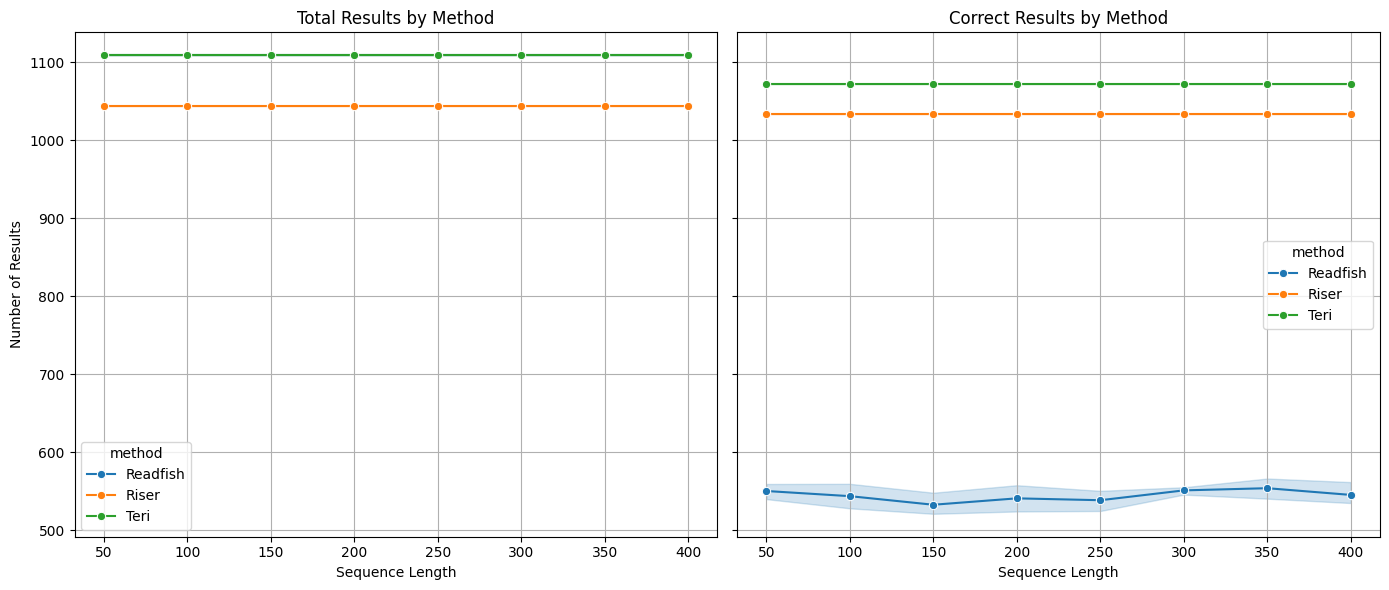

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plotting total alignments
sns.lineplot(data=df, x='length', y='total_results', hue='method', marker='o', ax=axs[0])
axs[0].set_title('Total Results by Method')
axs[0].set_xlabel('Sequence Length')
axs[0].set_ylabel('Number of Results')
axs[0].grid(True)

# Plotting correct alignments
sns.lineplot(data=df, x='length', y='correct_results', hue='method', marker='o', ax=axs[1])
axs[1].set_title('Correct Results by Method')
axs[1].set_xlabel('Sequence Length')
axs[1].set_ylabel('Number of Correct Results')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

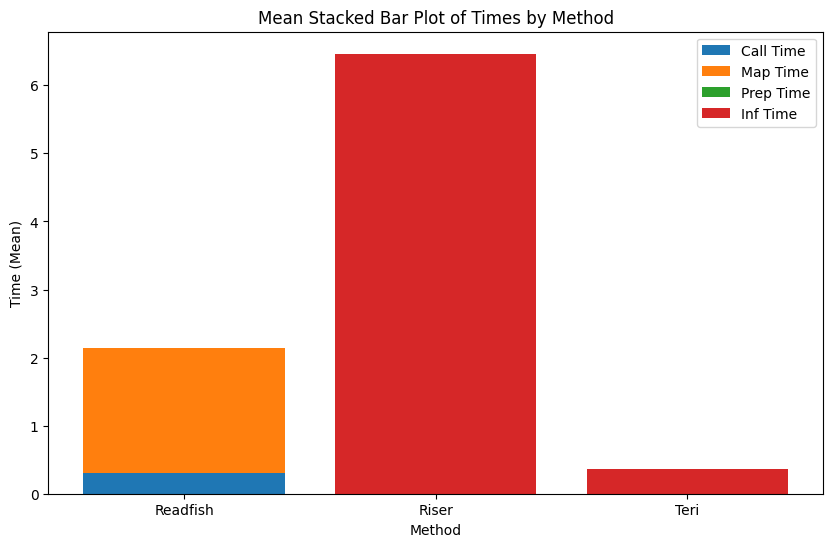

In [12]:
df_subset = df[df['length'] == 50]
df_mean = df_subset.groupby('method', as_index=False).mean()

# Set the figure size
plt.figure(figsize=(10, 6))

# Define the positions for the x-axis (methods)
methods = df_mean['method']

# Create the stacked bar plot
plt.bar(methods, df_mean['call_time'], label='Call Time')
plt.bar(methods, df_mean['map_time'], bottom=df_mean['call_time'], label='Map Time')
plt.bar(methods, df_mean['prep_time'], bottom=df_mean['call_time'] + df_mean['map_time'], label='Prep Time')
plt.bar(methods, df_mean['inf_time'], bottom=df_mean['call_time'] + df_mean['map_time'] + df_mean['prep_time'], label='Inf Time')

# Add labels and title
plt.xlabel('Method')
plt.ylabel('Time (Mean)')
plt.title('Mean Stacked Bar Plot of Times by Method')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [1]:
import seaborn as sns

# Create the bar plot using seaborn with error bars
plt.figure(figsize=(8, 6))
sns.barplot(x='method', y='total_time', hue='channel', data=df, ci='sd')  # ci='sd' adds standard deviation error bars

# Add labels and title
plt.xlabel('Method')
plt.ylabel('Total Time')
plt.title('Total Time by Method and Channel with Error Bars')

# Show the plot
plt.show()

NameError: name 'plt' is not defined